In [4]:
import re
import matplotlib.pyplot as plt

# Function to parse jemalloc stats
def parse_jemalloc_stats(filename):
    bin_data = []
    in_bins_section = False
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        if 'bins:' in line:
            in_bins_section = True
            continue
        
        if in_bins_section:
            # Exit when we reach the large allocations section
            if 'large:' in line:
                break
                
            # Skip headers and separators
            if line.strip().startswith('---') or not line.strip() or 'size ind' in line:
                continue
            
            # Parse bin data lines
            if re.match(r'^\s*\d+', line):
                parts = line.strip().split()
                try:
                    # print(line)
                    bin_size = int(parts[0])
                    allocated = int(parts[2])
                    nmalloc = int(parts[3])
                    # Calculate objects count (allocated bytes / bin size)
                    # num_objects = allocated // bin_size if bin_size > 0 else 0
                    bin_data.append((bin_size, nmalloc*bin_size))
                except (ValueError, IndexError):
                    continue
    
    return bin_data

# Function to create a bar chart
def create_bin_chart(bin_data):
    if not bin_data:
        print("No bin data found")
        return
    
    # Sort by bin size
    bin_data.sort(key=lambda x: x[0])
    
    bin_sizes = [str(size) for size, _ in bin_data]
    object_counts = [count for _, count in bin_data]
    
    plt.figure(figsize=(12, 6))
    plt.bar(bin_sizes, object_counts, color='skyblue')
    plt.xlabel('Bin Size (bytes)')
    plt.ylabel('Total allocations')
    plt.title('jemalloc Stats: nmalloc*bin_size')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage example within a Jupyter Notebook
# filename = '657_xz_s.txt'  # Replace with the path to your


In [7]:
bin_data = parse_jemalloc_stats('657_xz_s.txt')

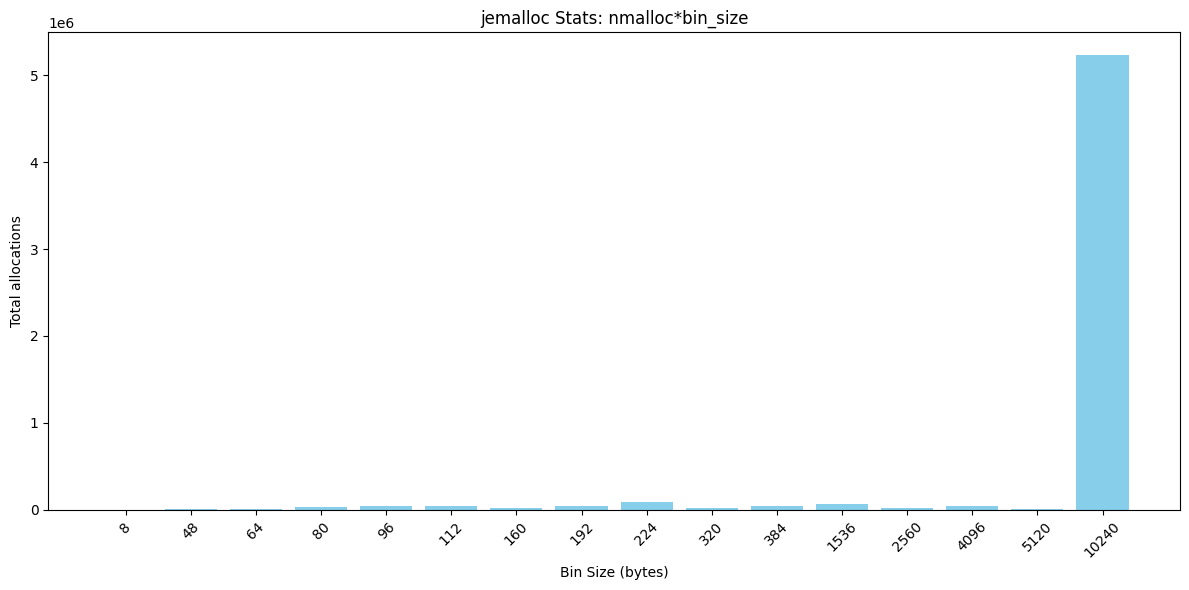

In [8]:
create_bin_chart(bin_data)

In [52]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def parse_jemalloc_stats(filename):
    """
    Parse jemalloc stats file to extract bins, large, and extents sections
    into separate pandas DataFrames with all columns.
    
    Parameters:
    -----------
    filename : str
        Path to the jemalloc stats file
        
    Returns:
    --------
    tuple
        (bins_df, large_df, extents_df) - DataFrames for each section
    """
    with open(filename, 'r') as f:
        content = f.read()
    
    # Parse bins section
    bins_data = []
    in_bins_section = False
    
    for line in content.split('\n'):
        if 'bins:' in line:
            in_bins_section = True
            continue
        
        if in_bins_section:
            if 'large:' in line:
                break
                
            if line.strip().startswith('---') or not line.strip() or 'size ind' in line:
                continue
                
            if re.match(r'^\s*\d+', line):
                parts = line.strip().split()
                # print(line)
                try:
                    bins_data.append({
                        'size': int(parts[0]),
                        'ind': int(parts[1]),
                        'allocated': int(parts[2]),
                        'nmalloc': int(parts[3]),
                        'ndalloc': int(parts[5]),
                        # 'nrequests': int(parts[7]),
                        # 'nshards': int(parts[8]),
                        # 'curregs': int(parts[9]),
                        # 'curslabs': int(parts[10]),
                        # 'nonfull_slabs': int(parts[11]),
                        # 'regs': int(parts[12]),
                        # 'pgs': int(parts[13]),
                        # 'util': float(parts[14]),
                        # 'nfills': int(parts[15]),
                        # 'nflushes': int(parts[17]),
                        # 'nslabs': int(parts[19]),
                        # 'nreslabs': int(parts[21]),
                        # 'pops': int(parts[23])
                    })
                except (ValueError, IndexError):
                    continue
    
    # Parse large section
    large_data = []
    in_large_section = 0
    
    for line in content.split('\n'):
        if 'large:' in line and in_large_section != 2:
            in_large_section += 1
            continue
        
        if in_large_section == 2:
            if 'extents:' in line:
                break
                
            if line.strip().startswith('---') or not line.strip() or 'size ind' in line:
                continue
                
            if re.match(r'^\s*\d+', line):
                parts = line.strip().split()
                try:
                    large_data.append({
                        'size': int(parts[0]),
                        'ind': int(parts[1]),
                        'allocated': int(parts[2]),
                        'nmalloc': int(parts[3]) if len(parts) > 3 else 0,
                        'ndalloc': int(parts[5]) if len(parts) > 5 else 0,
                        'nrequests': int(parts[7]) if len(parts) > 7 else 0,
                        'curlextents': int(parts[-1]) if len(parts) > 8 else 0
                    })
                except (ValueError, IndexError):
                    continue
    
    # Parse extents section
    extents_data = []
    in_extents_section = False
    
    for line in content.split('\n'):
        if 'extents:' in line:
            in_extents_section = True
            continue
        
        if in_extents_section:
            if line.strip().startswith('---') or not line.strip() or 'size ind' in line:
                continue
                
            if re.match(r'^\s*\d+', line):
                parts = line.strip().split()
                try:
                    extents_data.append({
                        'size': int(parts[0]),
                        'ind': int(parts[1]),
                        'ndirty': int(parts[2]),
                        'dirty': int(parts[3]),
                        'nmuzzy': int(parts[4]),
                        'muzzy': int(parts[5]),
                        'nretained': int(parts[6]),
                        'retained': int(parts[7]),
                        'ntotal': int(parts[8]),
                        'total': int(parts[9])
                    })
                except (ValueError, IndexError):
                    continue
    
    return pd.DataFrame(bins_data), pd.DataFrame(large_data), pd.DataFrame(extents_data)

def plot_column_bar_chart(df, column_name, x_column='size', scale='linear', title=None):
    """
    Plot a bar chart for a specific column from a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data.
        
    column_name : str
        The column to plot on the Y-axis.
        
    x_column : str, optional (default='size')
        The column to plot on the X-axis.
        
    title : str, optional (default=None)
        Title of the chart.
        
    Returns:
    --------
    None
        Displays the chart inline.
    """
    # Ensure the column exists
    if column_name not in df.columns or x_column not in df.columns:
        print(f"Column '{column_name}' or '{x_column}' not found.")
        return
    
    df_sorted = df.sort_values(x_column)
    
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted[x_column].astype(str), df_sorted[column_name], color='skyblue')
    
    plt.xlabel(x_column.capitalize())
    plt.ylabel(column_name.capitalize())
    
    chart_title = title or f"{column_name.capitalize()} vs {x_column.capitalize()}"
    plt.title(chart_title)
    
    plt.xticks(rotation=45)
    plt.yscale(scale)
    plt.tight_layout()
    
    plt.show()

# Example usage within a Jupyter Notebook
# filename = "657_xz_s.txt"  # Replace with your jemalloc stats file path

# # Parse the jemalloc stats into DataFrames
# bins_df, large_df, extents_df = parse_jemalloc_stats(filename)

# # Display the DataFrames for verification
# print("Bins DataFrame:")
# display(bins_df)

# print("\nLarge DataFrame:")
# display(large_df)

# print("\nExtents DataFrame:")
# display(extents_df)

# Plotting example: Number of objects per bin size ('curregs' column)
# plot_column_bar_chart(bins_df, column_name='curregs', title="Number of Objects per Bin Size")

# Plotting example: Utilization ratio ('util' column)
# plot_column_bar_chart(bins_df, column_name='util', title="Utilization Ratio per Bin Size")


In [53]:
xz_bins_df, xz_large_df, xz_extents_df = parse_jemalloc_stats(filename='657_xz_s.txt')


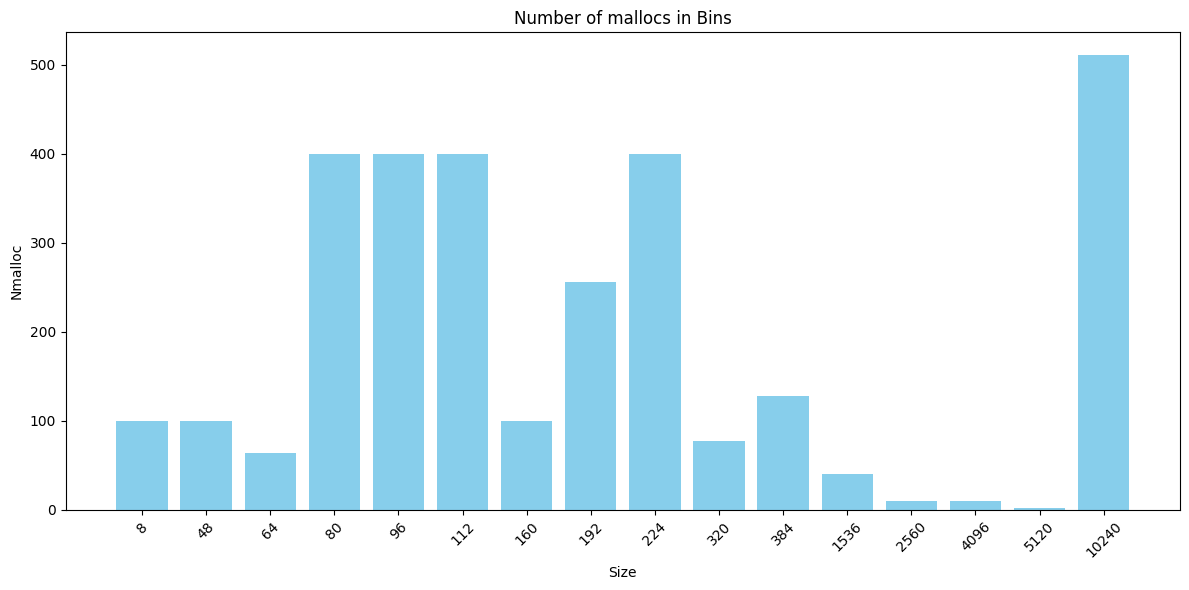

In [54]:
plot_column_bar_chart(xz_bins_df, column_name='nmalloc', title="Number of mallocs in Bins")

In [35]:
xz_bins_df, xz_large_df, xz_extents_df = parse_jemalloc_stats(filename='657_xz_s.txt')

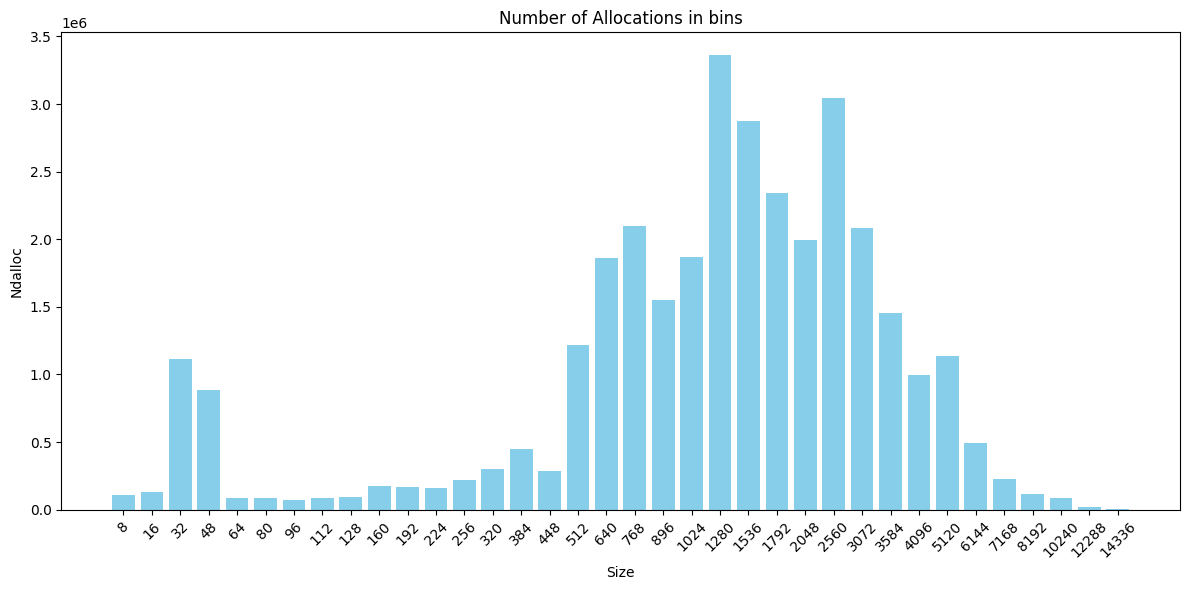

In [67]:
xa_bins_df, xa_large_df, xa_extents_df = parse_jemalloc_stats(filename='623_xalancbmk_s.txt')
plot_column_bar_chart(xa_bins_df, column_name='ndalloc', scale='linear', title="Number of Allocations in bins")

In [62]:
xa_large_df.head()

,size,ind,allocated,nmalloc,ndalloc,nrequests,curlextents
0,16384,36,0,1415,1415,2940,0
1,20480,37,0,36,36,3100,0
2,24576,38,0,15,15,3003,0
3,28672,39,28672,14,13,2143,1
4,32768,40,0,33,33,3227,0


In [68]:
import matplotlib.pyplot as plt

def plot_bar_chart(x_data, y_data, x_label='Bin size (Bytes)', y_label='Bytes', scale='linear', title=None):
    """
    Plot a bar chart for specific x and y data.

    Parameters:
    -----------
    x_data : pandas.Series
        The data to plot on the X-axis.
        
    y_data : pandas.Series
        The data to plot on the Y-axis.
        
    x_label : str, optional (default='X-axis')
        Label for the X-axis.
        
    y_label : str, optional (default='Y-axis')
        Label for the Y-axis.
        
    scale : str, optional (default='linear')
        The scale of the Y-axis ('linear' or 'log').
        
    title : str, optional (default=None)
        Title of the chart.
        
    Returns:
    --------
    None
        Displays the chart inline.
    """
    if len(x_data) != len(y_data):
        print("Error: x_data and y_data must have the same length.")
        return
    
    # Sort the data by x_data
    sorted_indices = x_data.argsort()
    x_data_sorted = x_data.iloc[sorted_indices]
    y_data_sorted = y_data.iloc[sorted_indices]
    
    plt.figure(figsize=(12, 6))
    plt.bar(x_data_sorted.astype(str), y_data_sorted, color='skyblue')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    chart_title = title or f"{y_label} vs {x_label}"
    plt.title(chart_title)
    
    plt.xticks(rotation=45)
    plt.yscale(scale)
    plt.tight_layout()
    
    plt.show()



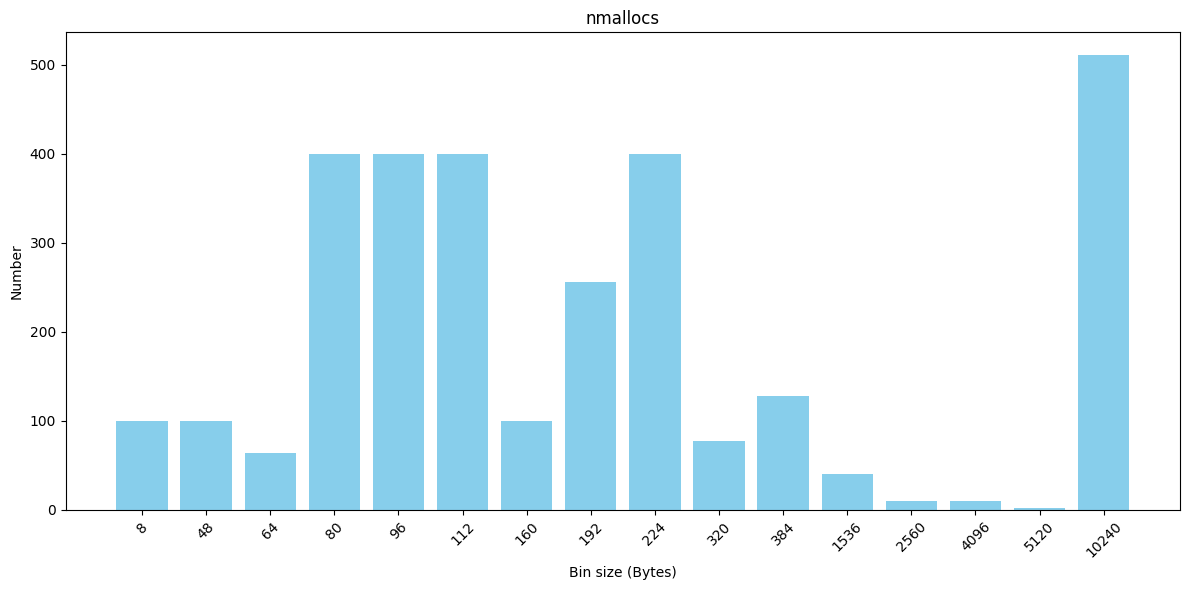

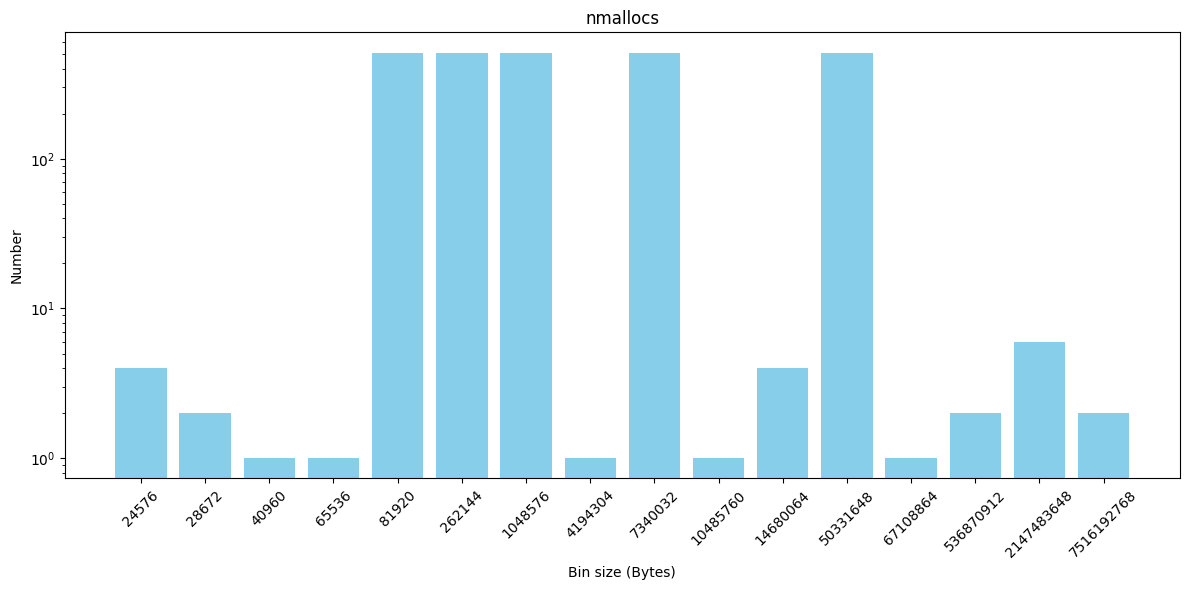

In [65]:
plot_bar_chart(xz_bins_df['size'], xz_bins_df['nmalloc'], y_label='Number', scale='linear', title='nmallocs')
plot_bar_chart(xz_large_df['size'], xz_large_df['nmalloc'], y_label='Number', scale='log', title='nmallocs')

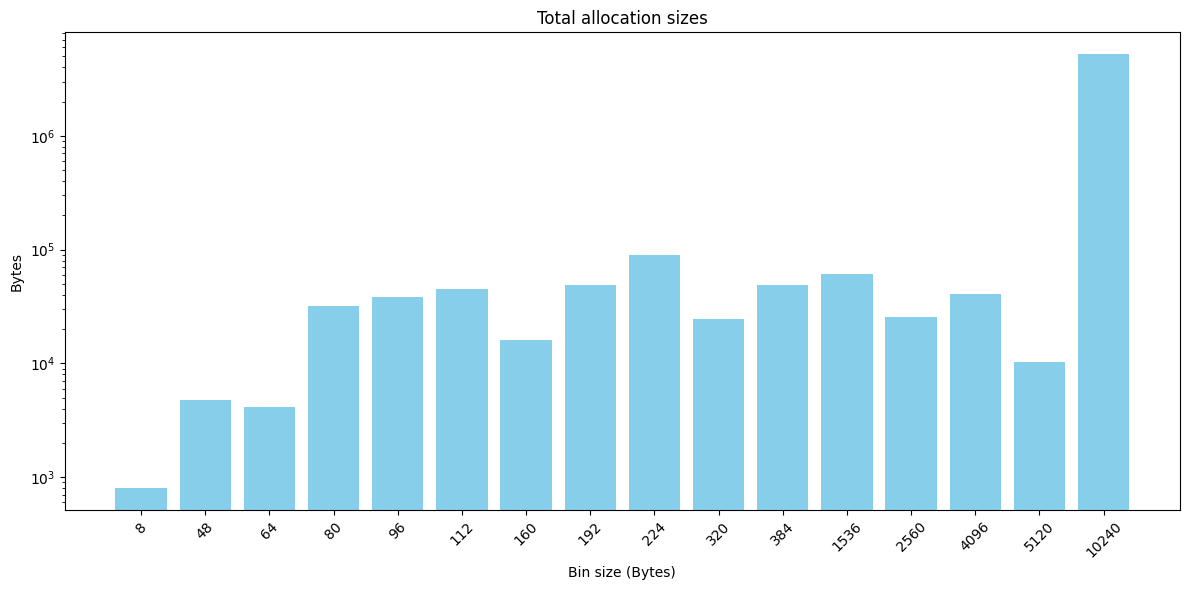

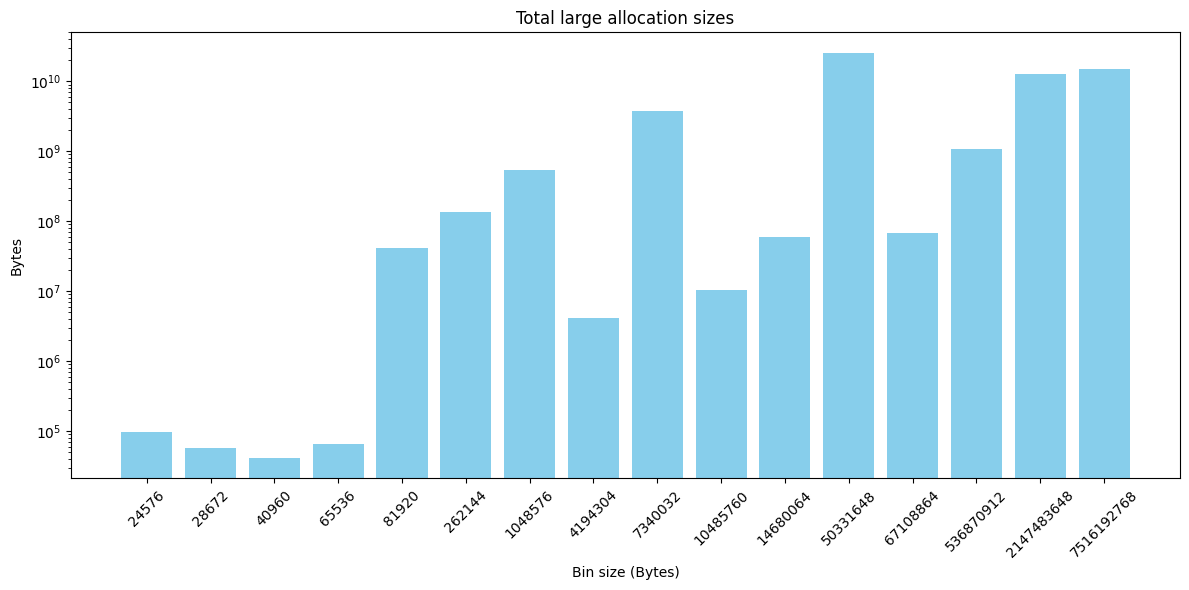

In [71]:
plot_bar_chart(xz_bins_df['size'], xz_bins_df['nmalloc'] * xz_bins_df['size'], scale='log', title='Total allocation sizes')
plot_bar_chart(xz_large_df['size'], xz_large_df['nmalloc'] * xz_large_df['size'], scale='log', title='Total large allocation sizes')

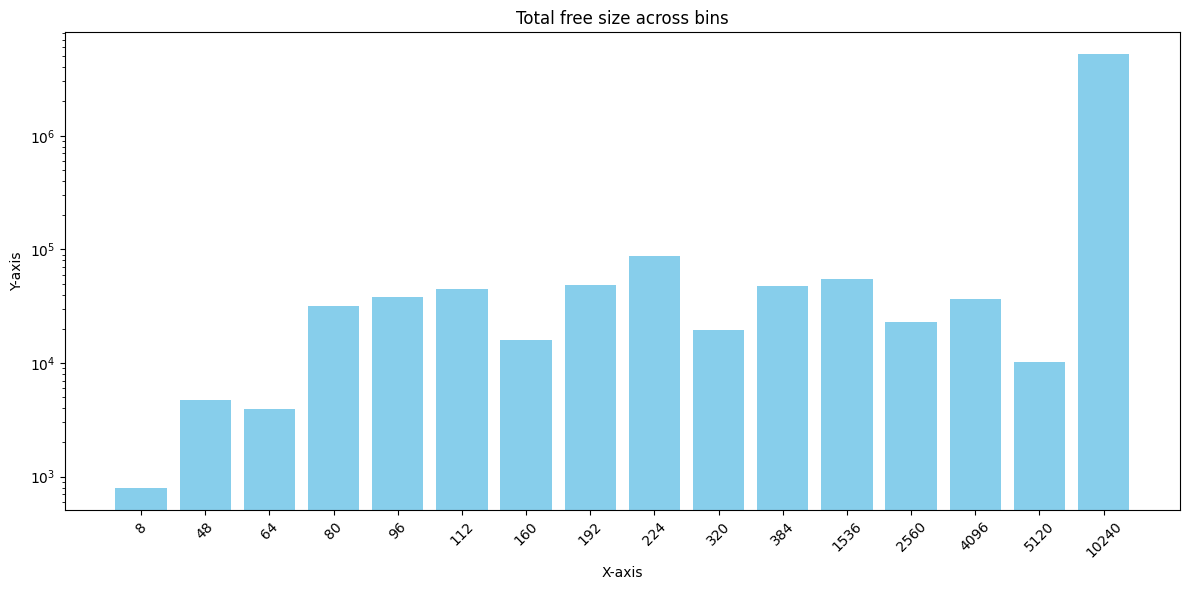

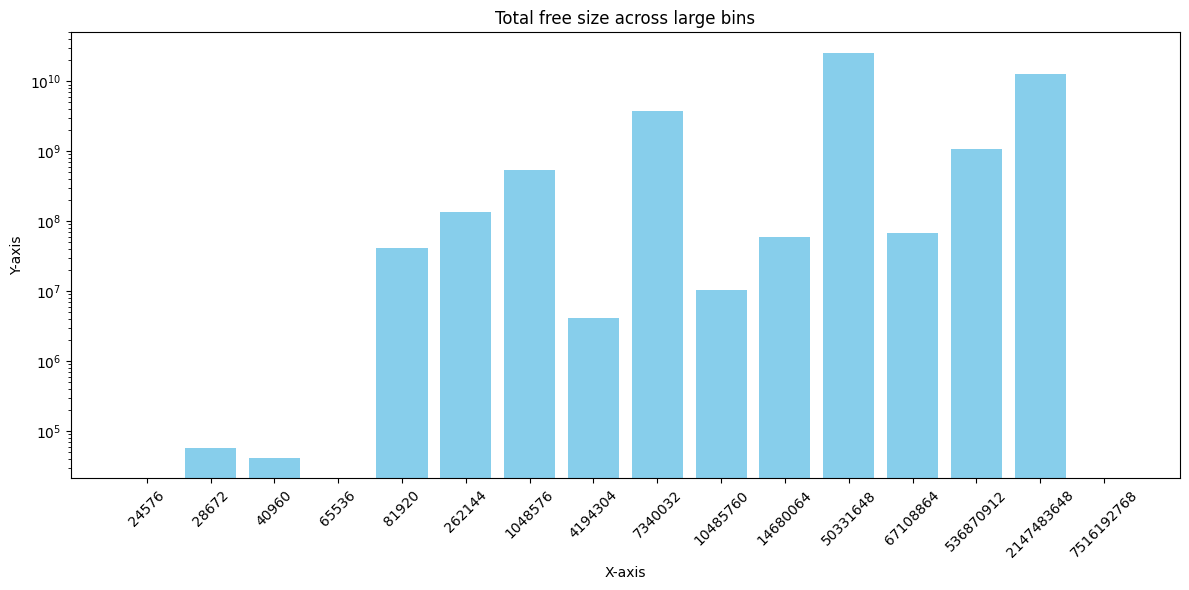

: 

In [ ]:
plot_bar_chart(xz_bins_df['size'], xz_bins_df['ndalloc'] * xz_bins_df['size'], scale='log', title='Total free size across bins')
plot_bar_chart(xz_large_df['size'], xz_large_df['ndalloc'] * xz_large_df['size'], scale='log', title='Total free size across large bins')

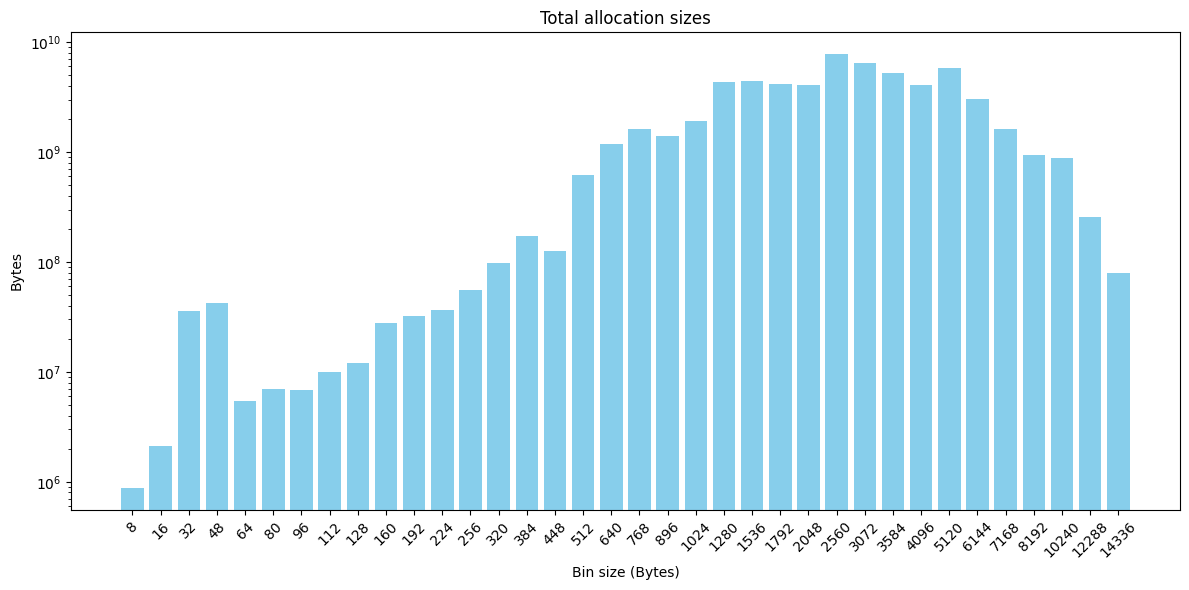

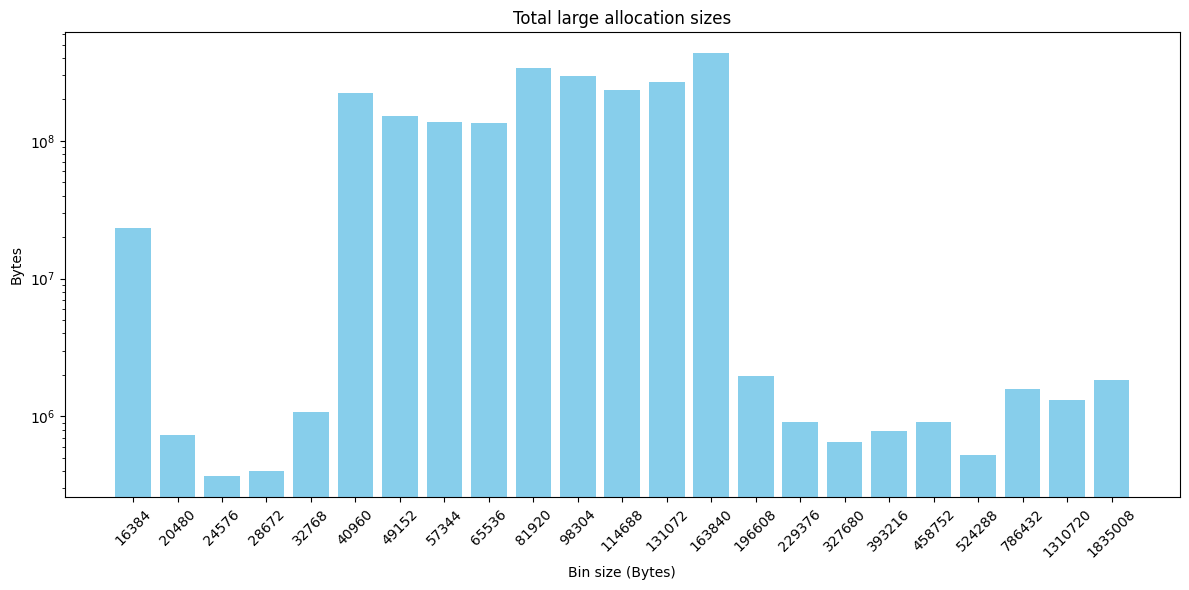

In [69]:
plot_bar_chart(xa_bins_df['size'], xa_bins_df['nmalloc'] * xa_bins_df['size'], y_label='Bytes', scale='log', title='Total allocation sizes')
plot_bar_chart(xa_large_df['size'], xa_large_df['nmalloc'] * xa_large_df['size'], y_label='Bytes', scale='log', title='Total large allocation sizes')

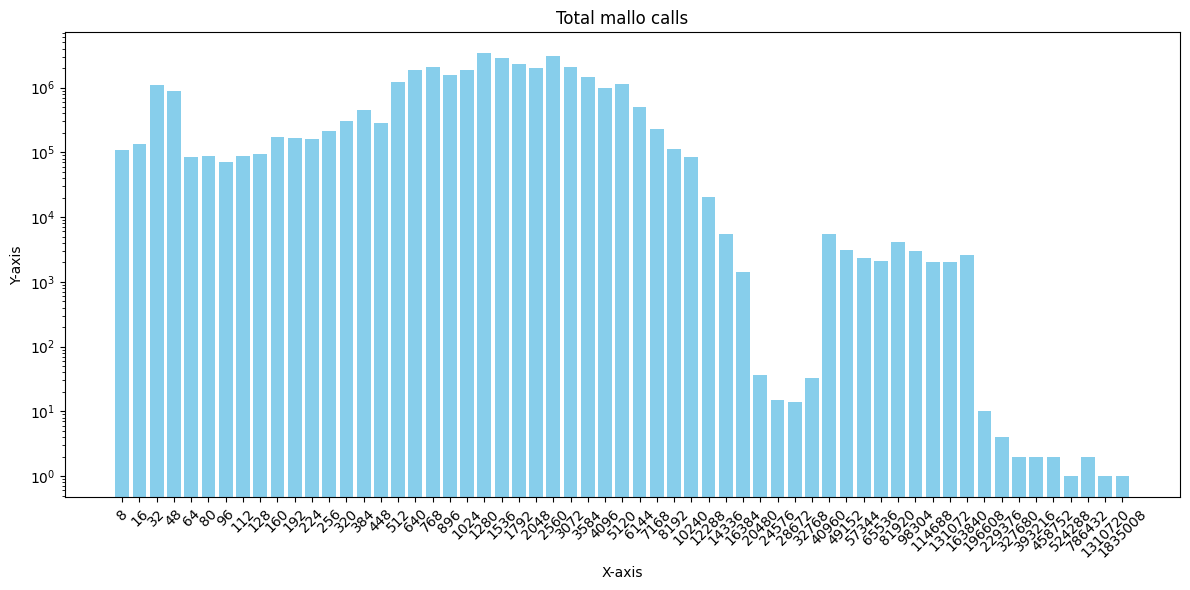

: 

In [ ]:
# plot_bar_chart(xa_bins_df['size'], xa_bins_df['nmalloc'], scale='log', title='Total malloc calls')
plot_bar_chart(xa_large_df['size'], xa_large_df['nmalloc'], scale='log', title='Total malloc calls')

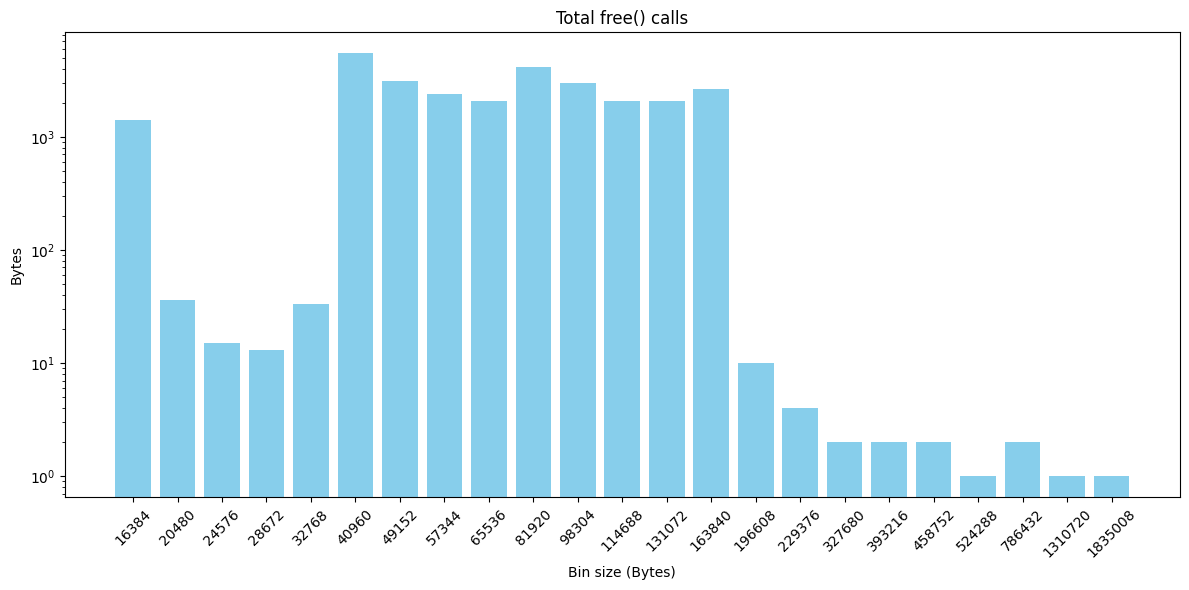

In [66]:
plot_bar_chart(xa_large_df['size'], xa_large_df['ndalloc'], scale='log', title='Total free() calls')

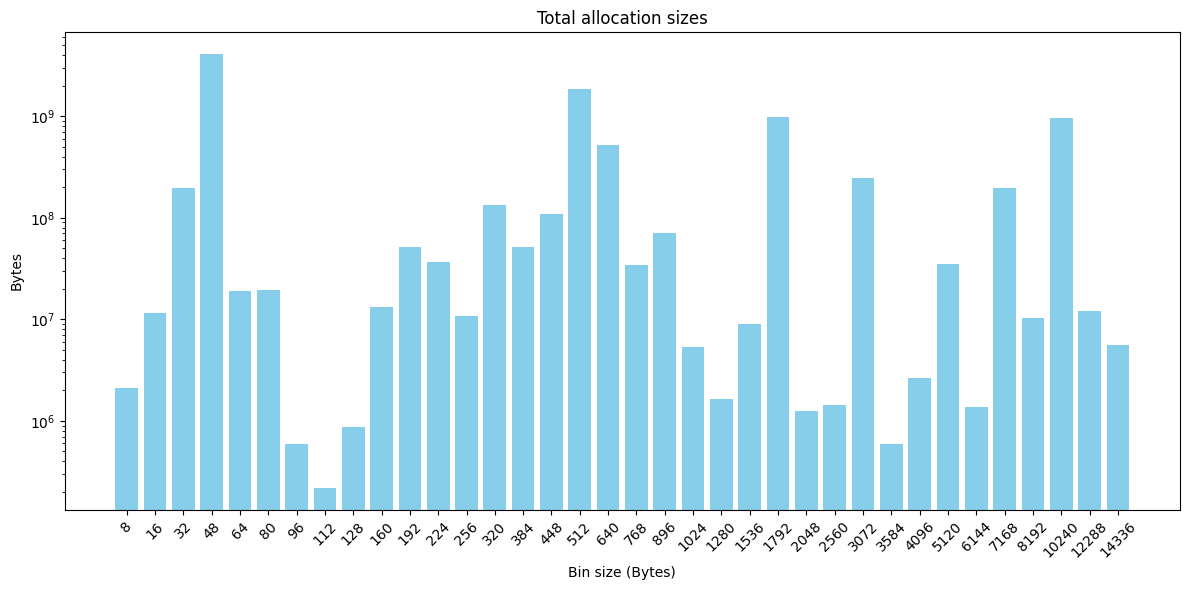

In [70]:
par_bins_df, par_large_df, par_extents_df = parse_jemalloc_stats(filename='510_parest_r.txt')
plot_bar_chart(par_bins_df['size'], par_bins_df['nmalloc'] * par_bins_df['size'], scale='log', title='Total allocation sizes')

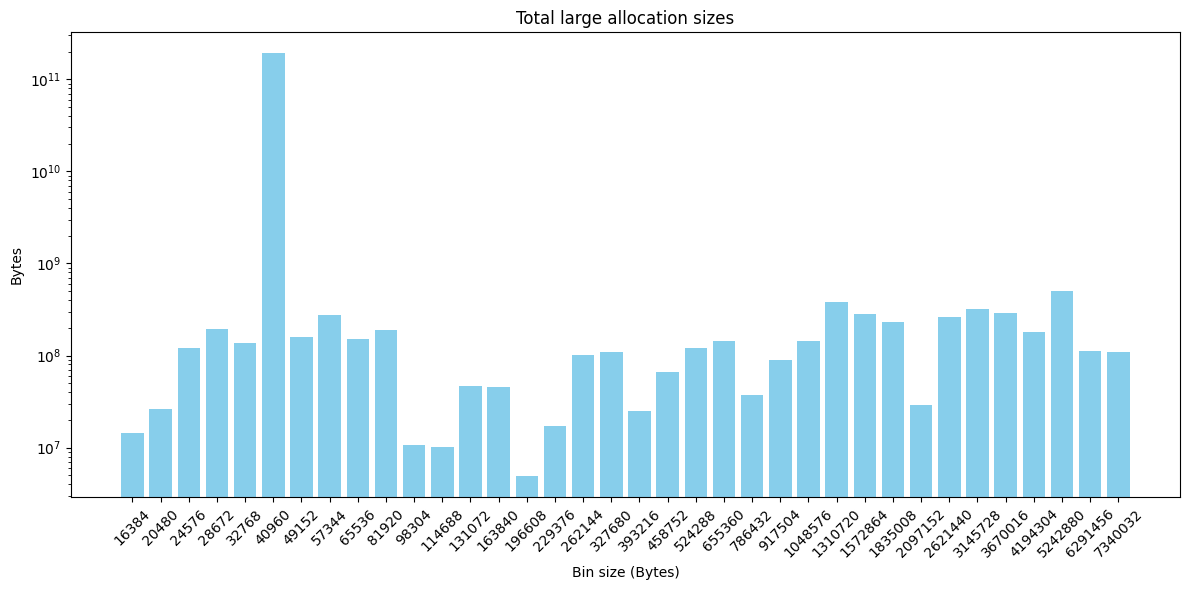

In [ ]:
plot_bar_chart(par_large_df['size'], par_large_df['nmalloc'] * par_large_df['size'], scale='log', title='Total large allocation sizes')

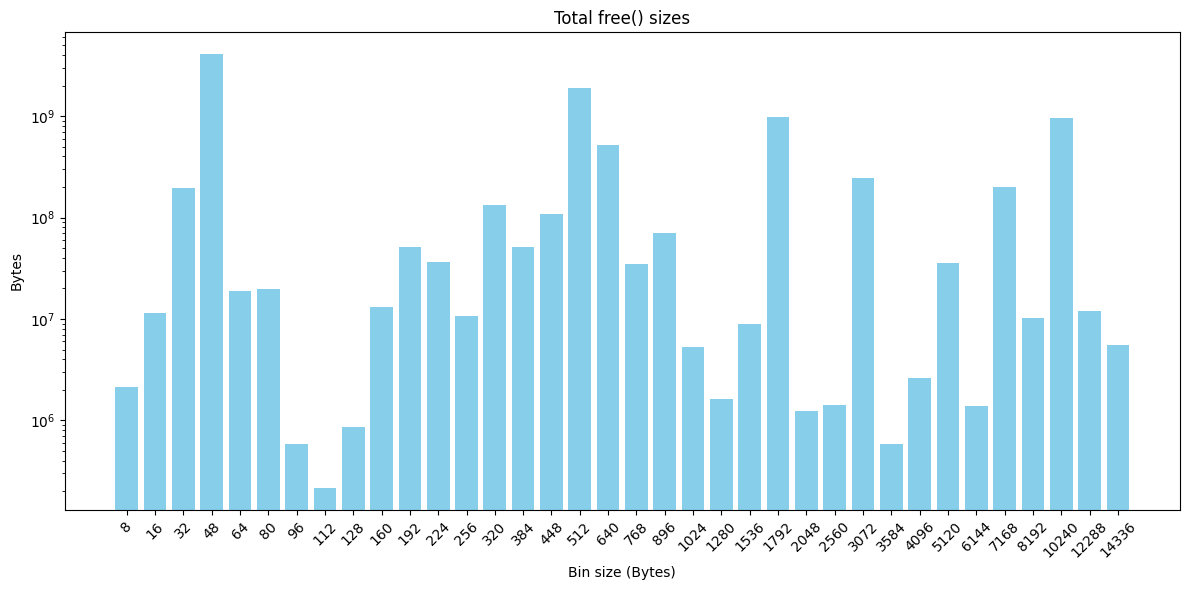

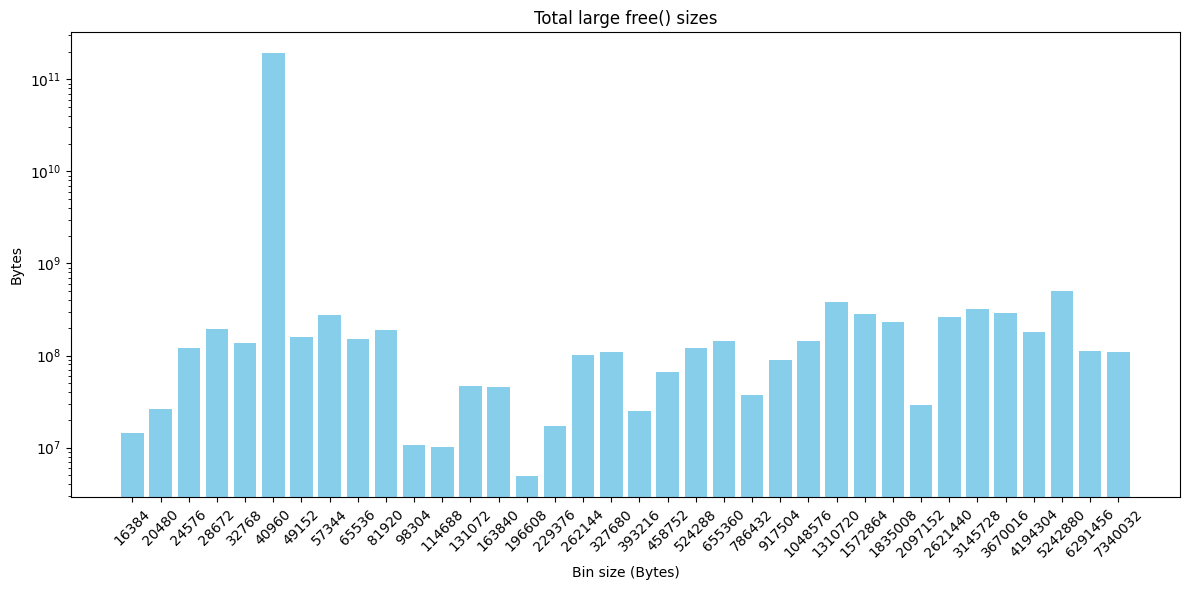

In [76]:
plot_bar_chart(par_bins_df['size'], par_bins_df['ndalloc'] * par_bins_df['size'], scale='log', title='Total free() sizes')
plot_bar_chart(par_large_df['size'], par_large_df['ndalloc'] * par_large_df['size'], scale='log', title='Total large free() sizes')

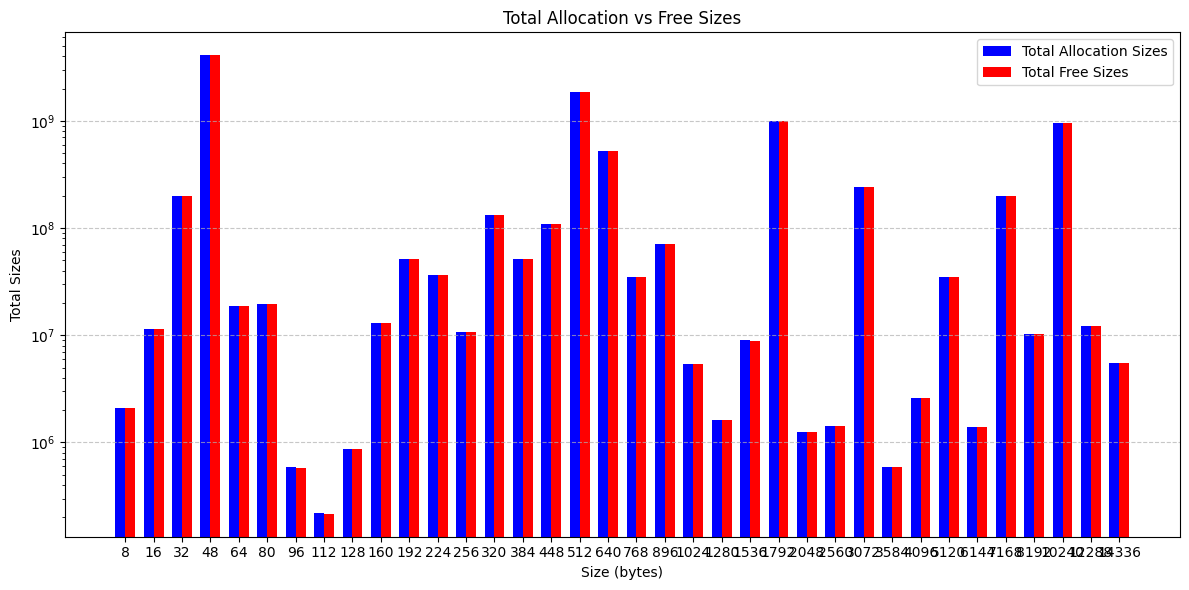

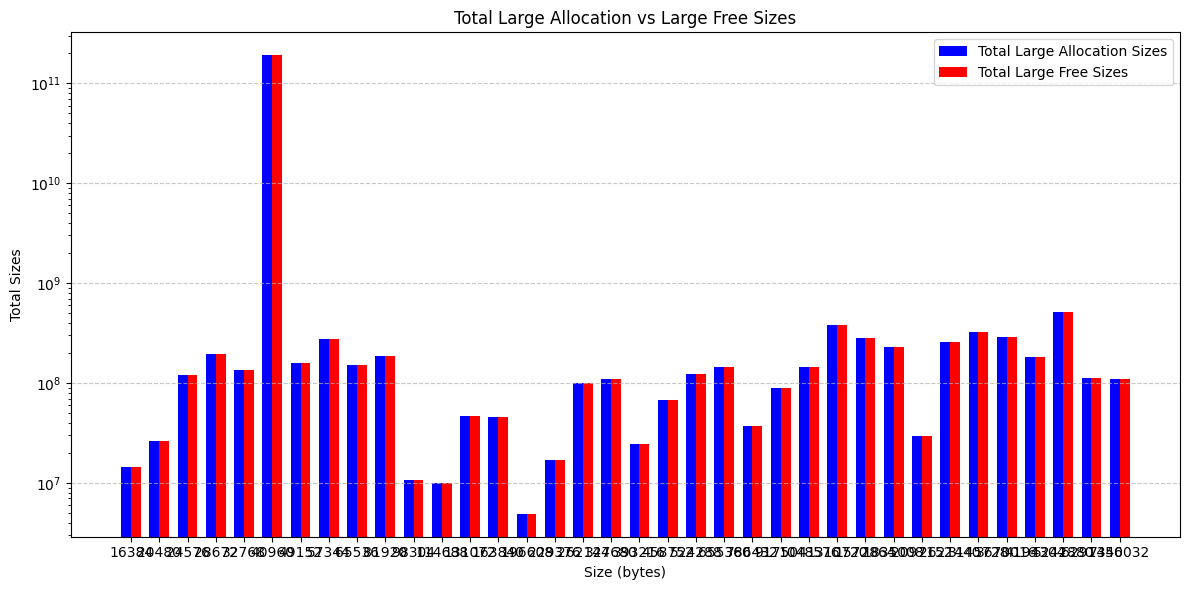

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_grouped_bars(x_data, y1_data, y2_data, labels, scale='linear', title=None):
    """
    Plot two datasets as grouped bars side by side.
    
    Parameters:
    -----------
    x_data : pandas.Series
        The data for the X-axis categories
    y1_data : pandas.Series
        The first dataset for Y-axis
    y2_data : pandas.Series
        The second dataset for Y-axis
    labels : list
        List of two strings for legend labels
    scale : str, optional (default='linear')
        The scale for Y-axis ('linear' or 'log')
    title : str, optional
        Title of the chart
    """
    plt.figure(figsize=(12, 6))
    
    x = range(len(x_data))
    width = 0.35  # Width of the bars
    
    # Plot bars side-by-side with correct labels
    plt.bar([i - width/2 for i in x], y1_data, width, color='blue', label=labels[0])
    plt.bar([i + width/2 for i in x], y2_data, width, color='red', label=labels[1])
    
    plt.xlabel('Size (bytes)')
    plt.ylabel('Total Sizes')
    plt.yscale(scale)
    plt.title(title or "Allocation vs Free Sizes")
    plt.xticks(x, x_data.astype(str))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# Usage
plot_grouped_bars(
    par_bins_df['size'], 
    par_bins_df['nmalloc'] * par_bins_df['size'],  # Total allocation sizes
    par_bins_df['ndalloc'] * par_bins_df['size'],  # Total free sizes
    labels=['Total Allocation Sizes', 'Total Free Sizes'], 
    scale='log', 
    title='Total Allocation vs Free Sizes'
)

plot_grouped_bars(
    par_large_df['size'], 
    par_large_df['nmalloc'] * par_large_df['size'],  # Total allocation sizes
    par_large_df['ndalloc'] * par_large_df['size'],  # Total free sizes
    labels=['Total Large Allocation Sizes', 'Total Large Free Sizes'], 
    scale='log', 
    title='Total Large Allocation vs Large Free Sizes'
)
